In [1]:
import lightgbm as lgb
import numpy as np
import pandas as pd
import os
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
import joblib

In [2]:

def agregar_lags(df, columna, lags):
    """Agrega variables de retardo (lags) al DataFrame."""
    for lag in lags:
        df[f'lag_{lag}'] = df[columna].shift(lag)
    return df

def agregar_medias_moviles(df, columna, ventanas):
    """Agrega variables de medias móviles al DataFrame."""
    for ventana in ventanas:
        df[f'media_movil_{ventana}'] = df[columna].shift(1).rolling(window=ventana, min_periods=1).mean()
    return df

def agregar_variables_ciclicas(df, columna_mes, columna_fecha):
    """Agrega variables cíclicas seno/coseno para mes y día de la semana."""
    df['mes_sin'] = np.sin(2 * np.pi * df[columna_mes] / 12)
    df['mes_cos'] = np.cos(2 * np.pi * df[columna_mes] / 12)
    df['dia_semana_sin'] = np.sin(2 * np.pi * pd.to_datetime(df[columna_fecha]).dt.weekday / 7)
    df['dia_semana_cos'] = np.cos(2 * np.pi * pd.to_datetime(df[columna_fecha]).dt.weekday / 7)
    return df

def agregar_ewma(df, columna, spans):
    """Agrega variables de Media Móvil Exponencial (EWMA) al DataFrame."""
    for span in spans:
        df[f'ewma_{span}'] = df[columna].shift(1).ewm(span=span, adjust=False).mean()
    return df

def obtener_semestre(mes):
    """Define la variable Semestre (1, 2 o 0)."""
    if 3 <= mes <= 7:
        return 1
    elif 8 <= mes <= 12:
        return 2
    else:
        return 0

In [4]:
try:
    daily_counts_full = pd.read_csv("Datasets/accesos_biblioteca.csv")
    print("Dataset cargado desde 'Datasets/daily_counts_full.csv'")
except FileNotFoundError:
    print("ERROR: No se encontró el archivo 'daily_counts_full.csv'.")
    exit(1)

# Aplicar transformaciones y crear features
for col in ['Accesos']:
    daily_counts_full[col] = daily_counts_full[col].fillna(0).astype(int)
daily_counts_full['Fecha'] = pd.to_datetime(daily_counts_full['Fecha'])
daily_counts_full = daily_counts_full[
    daily_counts_full['Fecha'].dt.weekday != 6 # Eliminar domingos
].reset_index(drop=True)

# Generar features de series temporales
daily_counts_full = agregar_medias_moviles(daily_counts_full, 'Accesos', [7, 14, 30])
daily_counts_full = agregar_variables_ciclicas(daily_counts_full, 'Mes', 'Fecha')
daily_counts_full = agregar_ewma(daily_counts_full, 'Accesos', [7, 14, 30])
daily_counts_full['Semestre'] = daily_counts_full['Mes'].apply(obtener_semestre)

# Generar Semana_Semestre y Semana_Certamen
def semana_en_semestre(row):
    if row['Semestre'] == 1:
        inicio = pd.Timestamp(year=row['Año'], month=3, day=1)
    elif row['Semestre'] == 2:
        inicio = pd.Timestamp(year=row['Año'], month=8, day=1)
    else:
        return np.nan
    return ((row['Fecha'] - inicio).days // 7) + 1

daily_counts_full['Semana_Semestre'] = daily_counts_full.apply(semana_en_semestre, axis=1)
daily_counts_full['Semana_Certamen'] = daily_counts_full['Semana_Semestre'].isin([6, 7]).astype(int)

# Agregar Lags
daily_counts_full = agregar_lags(daily_counts_full, 'Accesos', [7, 14, 21])

Dataset cargado desde 'Datasets/daily_counts_full.csv'


In [8]:
daily_counts_full = daily_counts_full.dropna().reset_index(drop=True)

# Usando el conjunto completo de features para un modelo robusto y consistente
FEATURES = ['Semana_Certamen', 'media_movil_7', 'media_movil_14', 'media_movil_30',
            'mes_sin', 'mes_cos', 'dia_semana_sin', 'dia_semana_cos',
            'lag_7', 'lag_14', 'lag_21', 'ewma_7', 'ewma_14', 'ewma_30']
TARGET = 'Accesos'

X = daily_counts_full[FEATURES]
y = daily_counts_full[TARGET]

# 80/20 split, shuffle=False para series temporales
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# Data Augmentation para el set de entrenamiento
X_train_aug = [X_train.copy()]
y_train_aug = [y_train.copy()]
N_AUGMENTATIONS = 4

for i in range(N_AUGMENTATIONS):
    if i % 2 == 0:
        y_new = y_train * np.random.uniform(0.95, 1.05, len(y_train))
    else:
        y_new = y_train + np.random.normal(0, y_train.std() * 0.02, len(y_train))
    
    df_new = X_train.copy()
    df_new['Accesos'] = y_new

    # Recalcular features (manteniendo las columnas no dependientes del target)
    df_new = df_new.drop(columns=[col for col in df_new.columns if 'media_movil' in col or 'ewma' in col or 'lag_' in col], errors='ignore')
    df_new = agregar_medias_moviles(df_new, 'Accesos', [7, 14, 30])
    df_new = agregar_ewma(df_new, 'Accesos', [7, 14, 30])
    df_new = agregar_lags(df_new, 'Accesos', [7, 14, 21])

    df_new = df_new.dropna().reset_index(drop=True)
    
    X_train_aug.append(df_new[FEATURES])
    y_train_aug.append(df_new['Accesos'])

X_train_final = pd.concat(X_train_aug)
y_train_final = pd.concat(y_train_aug)

print(f"\n")
print(f"Preparación de Datos Finalizada")
print(f"Datos de entrenamiento: {len(y_train)} | Datos de prueba: {len(y_test)}")
print(f"Número de Features Exógenas: {len(FEATURES)}")



Preparación de Datos Finalizada
Datos de entrenamiento: 256 | Datos de prueba: 64
Número de Features Exógenas: 14


In [9]:
# Entrenamiento y Evaluación con LightGBM
# Configuración de búsqueda de hiperparámetros
tscv = TimeSeriesSplit(n_splits=5)
param_grid = {
    'n_estimators': [300, 500, 700],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [20, 31, 40],
    'max_depth': [-1, 10, 20],
    'min_child_samples': [10, 20, 30],
}

print("\nIniciando entrenamiento y ajuste de hiperparámetros de LightGBM...")

# 1. Búsqueda de Hyperparámetros
grid_search = GridSearchCV(
    lgb.LGBMRegressor(random_state=42, n_jobs=-1, objective='regression'),
    param_grid,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train_final, y_train_final)

print(f'Mejores parámetros para LightGBM: {grid_search.best_params_}')

# 2. Entrenamiento del modelo final con los mejores parámetros
best_params = grid_search.best_params_
model = lgb.LGBMRegressor(**best_params, random_state=42, n_jobs=-1, objective='regression')
model.fit(X_train_final, y_train_final)

# Guardar el modelo
os.makedirs(os.path.dirname('Archivos Auxiliares/'), exist_ok=True)
joblib.dump(model, 'Archivos Auxiliares/modelo_LightGBM.pkl')
print("Modelo LightGBM guardado como 'Archivos Auxiliares/modelo_LightGBM.pkl'")


Iniciando entrenamiento y ajuste de hiperparámetros de LightGBM...
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000492 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2329
[LightGBM] [Info] Number of data points in the train set: 1196, number of used features: 14
[LightGBM] [Info] Start training from score 1654.501506
Mejores parámetros para LightGBM: {'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 10, 'n_estimators': 700, 'num_leaves': 20}
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000388 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2329
[LightGBM] [Info] Number of data points in the train set: 1196, number of used features: 14
[LightGBM] [Info] Start training from score 1654.501506
Modelo LightGBM guardado como 'Archivos Au


--- Evaluación de rendimiento de LightGBM en el set de prueba ---
R²: 0.46
Error Cuadrático Medio (MSE): 1189453.98
Error Cuadrático Medio Raíz (RMSE): 1090.62
Error Absoluto Medio (MAE): 731.64

Se han generado las siguientes visualizaciones:
- lightgbm_predicciones.png (Comparación de valores reales vs. predichos)
- lightgbm_importancia.png (Importancia de las variables)


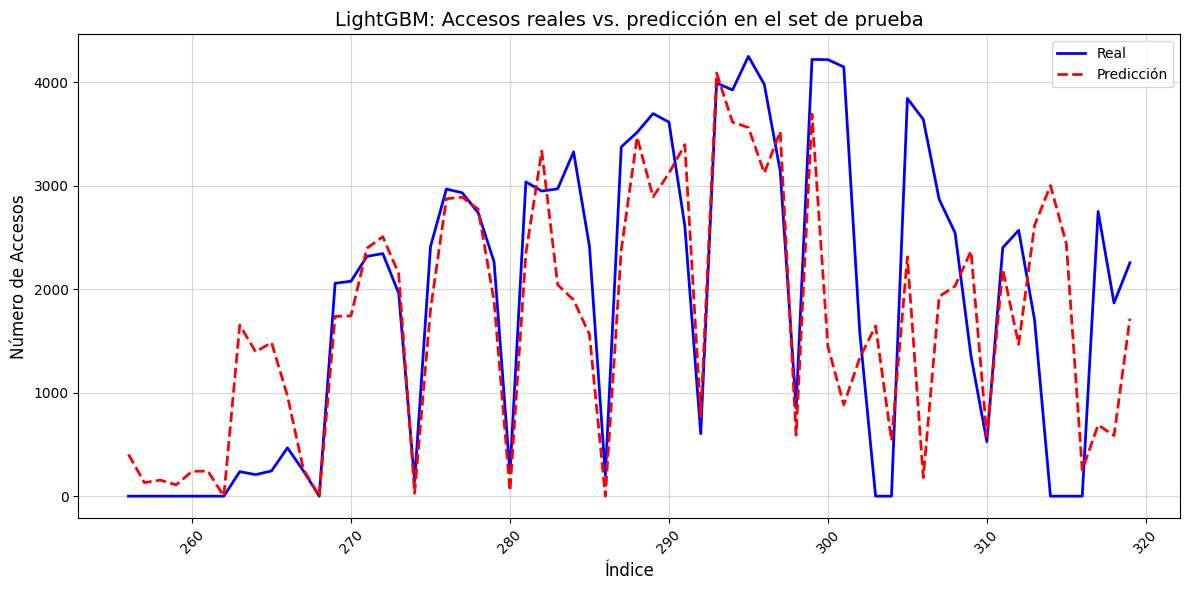

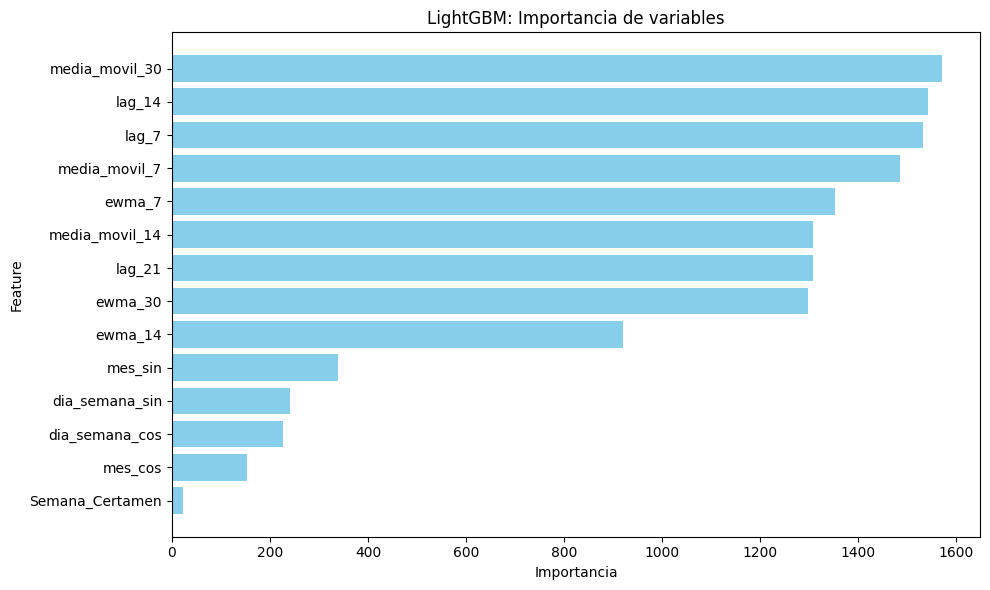

In [10]:
# Evaluación de rendimiento
predicted = model.predict(X_test)
predicted = np.maximum(predicted, 0)

# Cálculo de métricas
mse = mean_squared_error(y_test, predicted)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predicted)
r2 = r2_score(y_test, predicted)

print("\n--- Evaluación de rendimiento de LightGBM en el set de prueba ---")
print(f"R²: {r2:.2f}")
print(f"Error Cuadrático Medio (MSE): {mse:.2f}")
print(f"Error Cuadrático Medio Raíz (RMSE): {rmse:.2f}")
print(f"Error Absoluto Medio (MAE): {mae:.2f}")

# Graficar resultados de la predicción (Real vs. Predicción en el test set)
results_df = pd.DataFrame({
    'Índice': X_test.index,
    'Real': y_test,
    'Predicción': predicted
}).sort_values(by='Índice')

plt.figure(figsize=(12, 6))
plt.plot(results_df['Índice'], results_df['Real'], label='Real', color='blue', linewidth=2)
plt.plot(results_df['Índice'], results_df['Predicción'], label='Predicción', color='red', linestyle='--', linewidth=2)
plt.title('LightGBM: Accesos reales vs. predicción en el set de prueba', fontsize=14)
plt.xlabel('Índice', fontsize=12)
plt.ylabel('Número de Accesos', fontsize=12)
plt.xticks(rotation=45)
plt.legend(fontsize=10)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.savefig('lightgbm_predicciones.png')


# Graficar importancia de variables
importances = model.feature_importances_
importance_df = pd.DataFrame({"Feature": FEATURES, "Importance": importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"], importance_df["Importance"], color='skyblue')
plt.xlabel("Importancia")
plt.ylabel("Feature")
plt.title("LightGBM: Importancia de variables")
plt.gca().invert_yaxis() 
plt.tight_layout()
plt.savefig('lightgbm_importancia.png')

print("\nSe han generado las siguientes visualizaciones:")
print("- lightgbm_predicciones.png (Comparación de valores reales vs. predichos)")
print("- lightgbm_importancia.png (Importancia de las variables)")